In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install deepMIMO

In [3]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 29.5 MB/s eta 0:00:00


In [4]:
import DeepMIMO
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt
import tensorflow as tf


parameters = {}
parameters['dynamic_settings'] = {}
parameters['OFDM'] = {}
parameters['bs_antenna'] = {}
parameters['ue_antenna'] = {}

parameters['dataset_folder'] = '/content/drive/MyDrive/scenarios'
parameters['scenario'] = 'O1_60'
parameters['dynamic_settings']['first_scene'] = 1
parameters['dynamic_settings']['last_scene'] = 1

parameters['num_paths'] = 5
parameters['active_BS'] = np.array([1])
parameters['user_row_first'] = 1
parameters['user_row_last'] = 1
parameters['row_subsampling'] = 1
parameters['user_subsampling'] = 1

parameters['bs_antenna']['shape'] = np.array([1, 8, 4])
parameters['bs_antenna']['spacing'] = 0.5
parameters['bs_antenna']['radiation_pattern'] = 'isotropic'

parameters['ue_antenna']['shape'] = np.array([1, 4, 2])
parameters['ue_antenna']['spacing'] = 0.5
parameters['ue_antenna']['radiation_pattern'] = 'isotropic'

parameters['enable_BS2BS'] = 1

parameters['OFDM_channels'] = 1
parameters['OFDM']['subcarriers'] = 512
parameters['OFDM']['subcarriers_limit'] = 64
parameters['OFDM']['subcarriers_sampling'] = 1
parameters['OFDM']['bandwidth'] = 0.05
parameters['OFDM']['RX_filter'] = 0

DeepMIMO_dataset = DeepMIMO.generate_data(parameters)

basestation_index = 0
user_index = 1

# Access the channel matrix for the specified base station and user
channel_matrix = DeepMIMO_dataset[basestation_index]['user']['channel'][user_index]

num_rows, num_columns, num_subcarriers = channel_matrix.shape
channel_matrix = channel_matrix.reshape(num_rows, -1)

# Convert complex data to real data before standardization
channel_matrix_real = np.real(channel_matrix)
channel_matrix_imag = np.imag(channel_matrix)

# Standardize the real and imaginary parts separately
scaler_real = StandardScaler()
scaler_imag = StandardScaler()

channel_matrix_real = scaler_real.fit_transform(channel_matrix_real)
channel_matrix_imag = scaler_imag.fit_transform(channel_matrix_imag)

# Combine the real and imaginary parts back into a complex matrix
channel_matrix = channel_matrix_real + 1j * channel_matrix_imag

num_samples = 1000
num_antennas = channel_matrix.shape[1]

X_train = np.random.randn(num_samples, channel_matrix.shape[0], channel_matrix.shape[1])

y_train = np.random.randn(num_samples, num_antennas)
y_test = np.random.randn(num_samples, num_antennas)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a custom loss function with Elastic Net regularization
def elastic_net_loss(l1, l2):
    def custom_loss(y_true, y_pred):
        l1_loss = l1 * tf.reduce_sum(tf.abs(y_pred))
        l2_loss = l2 * tf.reduce_sum(tf.square(y_pred))
        mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
        return mse_loss + l1_loss + l2_loss
    return custom_loss

def model_builder(hp):
    input_shape = (8, 2048)

    model = keras.Sequential()

    model.add(layers.Input(shape=input_shape))

    # Tune the number of convolutional layers
    for i in range(hp.Int('conv_layers', min_value=1, max_value=4)):
        l1 = hp.Float(f'l1_{i}', min_value=1e-5, max_value=1e-1)
        l2 = hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-1)
        model.add(layers.Conv1D(hp.Int(f'conv_units_{i}', min_value=16, max_value=128), kernel_size=3, activation='relu'))

    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(num_antennas, activation='linear'))

    # Use the custom loss function with Elastic Net regularization
    model.compile(optimizer='adam', loss=elastic_net_loss(l1, l2))

    return model

# Define the hyperparameter search space
tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='beamforming_tuning'
)

# Start hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model based on the hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

best_model_pred = best_model.predict(X_test)
best_model_mse = mean_squared_error(y_test, best_model_pred)
print("Best Model Mean Squared Error:", best_model_mse)
beamforming_weights = best_model_pred

Trial 24 Complete [00h 00m 06s]
val_loss: 1.1337652206420898

Best val_loss So Far: 1.0034935474395752
Total elapsed time: 00h 01m 20s
Epoch 1/10
20/20 [==============================] - 1s 22ms/step - loss: 1.0297 - val_loss: 1.0140
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 1.0068 - val_loss: 1.0065
Epoch 3/10
20/20 [==============================] - 0s 16ms/step - loss: 1.0003 - val_loss: 1.0043
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 0.9989 - val_loss: 1.0039
Epoch 5/10
20/20 [==============================] - 0s 16ms/step - loss: 0.9986 - val_loss: 1.0038
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.9986 - val_loss: 1.0038
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.9986 - val_loss: 1.0038
Epoch 8/10
20/20 [==============================] - 0s 19ms/step - loss: 0.9986 - val_loss: 1.0038
Epoch 9/10
20/20 [==============================] - 1s 31ms/step - loss: 

In [75]:
import numpy as np

np.random.seed(0)

transmitted_data = np.random.randn(1000) + 1j * np.random.randn(1000)

channel_matrix = np.random.randn(1000, 256) + 1j * np.random.randn(1000, 256)

beamforming_weights = np.random.randn(256) + 1j * np.random.randn(256)


learning_rate = 0.01
epochs = 100

# Gradient Descent to optimize beamforming weights
for epoch in range(epochs):
    error = 0
    gradient = np.zeros(beamforming_weights.shape, dtype=complex)

    for symbol in range(transmitted_data.shape[0]):
        # Calculate the received signal for each symbol using the current beamforming weights
        received_signal = np.dot(channel_matrix[symbol], beamforming_weights)

        # Calculate the MSE
        symbol_error = np.abs(transmitted_data[symbol] - received_signal)**2
        error += symbol_error

        # Calculate the gradient
        symbol_gradient = -2 * np.conj(channel_matrix[symbol]) * (transmitted_data[symbol] - received_signal)
        gradient += symbol_gradient

    # Update beamforming weights using the average gradient
    beamforming_weights -= learning_rate * (1.0 / transmitted_data.shape[0]) * gradient

    average_error = error / transmitted_data.shape[0]

    print(f"Epoch {epoch + 1}, Average MSE: {average_error}")

print("Optimized Beamforming Weights:", beamforming_weights)

Epoch 1, Average MSE: 1038.364218885681
Epoch 2, Average MSE: 932.7750043762554
Epoch 3, Average MSE: 839.4833428951908
Epoch 4, Average MSE: 756.926547401874
Epoch 5, Average MSE: 683.7522745342637
Epoch 6, Average MSE: 618.7890722875668
Epoch 7, Average MSE: 561.0211693119456
Epoch 8, Average MSE: 509.56688207798294
Epoch 9, Average MSE: 463.66010937031757
Epoch 10, Average MSE: 422.634462672938
Epoch 11, Average MSE: 385.9096481620269
Epoch 12, Average MSE: 352.9797730492445
Epoch 13, Average MSE: 323.40329746328496
Epoch 14, Average MSE: 296.79439422709214
Epoch 15, Average MSE: 272.81551388735505
Epoch 16, Average MSE: 251.17098211810006
Epoch 17, Average MSE: 231.6014819435222
Epoch 18, Average MSE: 213.87929477822672
Epoch 19, Average MSE: 197.80419263432864
Epoch 20, Average MSE: 183.19988947656384
Epoch 21, Average MSE: 169.91097302729705
Epoch 22, Average MSE: 157.8002496796199
Epoch 23, Average MSE: 146.74644486264128
Epoch 24, Average MSE: 136.64220946795692
Epoch 25, Avera

In [76]:
import numpy as np

# Replicate the optimized beamforming weights for each channel realization
num_realizations = channel_matrix.shape[0]
replicated_beamforming_weights = np.tile(beamforming_weights, (num_realizations, 1))

# Apply the replicated beamforming weights to the channel matrix
received_signal = np.sum(channel_matrix * replicated_beamforming_weights, axis=1) * transmitted_data

# Perform the reception process
received_data = np.conj(np.sum(channel_matrix * replicated_beamforming_weights, axis=1)) * received_signal

mse = np.mean(np.abs(transmitted_data - received_data)**2)
print("MSE with optimized beamforming:", mse)
print(beamforming_weights)

MSE with optimized beamforming: 37.54905761373064
[ 0.00745294-0.05752868j -0.1934506 -0.00914342j -0.12673309-0.01021594j
  0.0653877 +0.13262403j -0.00978121+0.12393929j  0.17110052-0.01896053j
  0.0141753 -0.00375791j -0.03013147+0.17218062j  0.07948658-0.1493145j
  0.11132302+0.04305665j  0.0443632 -0.02160429j  0.10981662-0.02536469j
 -0.02216696+0.01211816j -0.0342624 +0.00840834j -0.00555768+0.03159682j
 -0.02241841+0.03739489j -0.05707522-0.06077433j  0.02795922-0.02258946j
 -0.12886916-0.05238498j  0.17061082+0.1400241j   0.06543186-0.00825022j
 -0.14247055+0.18504916j -0.05695537+0.05019572j  0.01864276-0.13010165j
  0.08806864+0.0154796j   0.16765324+0.04135372j  0.22210176+0.09642398j
 -0.07705757+0.03489016j  0.00519271+0.01426152j  0.00227448+0.07570973j
 -0.09076659-0.04759338j -0.03141175-0.02878325j -0.06701809-0.08174179j
  0.14106873+0.01486835j  0.08023057+0.10396423j -0.22583838-0.00837566j
 -0.11123561+0.09851701j -0.10413258+0.03755358j -0.08284551+0.06122332j
 -

In [77]:
snr_db = 10 * np.log10(transmitted_data / mse)

print("SNR (in dB):", snr_db)

SNR (in dB): [-13.0752408 +1.32593757e+00j -15.84225811+4.99134629e+00j
 -15.46856771-1.76911661e+00j -12.23704244+2.02792654e-01j
 -13.00110835+5.27717832e-01j -15.75542155+1.27607742e+01j
 -15.35896179+2.24726197e+00j -13.13486813-7.18260546e+00j
 -25.16179069-1.17077719e+01j -18.9780614 +2.28959092e+00j
 -15.69999126-6.20078438e+00j -12.28742774+3.71546603e+00j
 -16.83620946+9.08468739e-01j -13.79216315+6.48456359e+00j
 -16.17178662-4.59996763e+00j -15.89301938-5.29136858e+00j
 -13.95387814+6.47019837e-01j -13.46409607-7.35002886e+00j
 -19.95083901+2.61317089e+00j -16.40297066+1.31515373e+01j
 -11.35644752+1.19993620e+01j -15.93017802+3.56291282e+00j
 -15.92342587-1.95394658e+00j -14.52422397-9.40418468e+00j
 -11.20791927+2.80689658e+00j -13.55515769-1.14778342e+01j
 -15.54849263-6.63192930e+00j -15.32856607-7.56391848e+00j
 -12.96581542+2.73556203e+00j -13.81950321-1.47432540e+00j
 -16.88409166-5.94132261e+00j -19.69887945+1.51647999e+00j
 -16.14801235-1.26491744e+01j -12.5369507 -

In [78]:
import numpy as np

magnitude_values = np.abs(snr_db)

mean_snr = np.mean(magnitude_values)

mean_snr_db = 10 * np.log10(mean_snr)

print("Mean SNR in dB:", mean_snr_db)


Mean SNR in dB: 12.437724345430672


In [79]:
snr_linear = 10 ** (snr_db / 10)
S = snr_linear * mse
total_received_power = S / snr_linear
I_plus_N = total_received_power - S
sinr_linear = S / I_plus_N
sinr_db = 10 * np.log10(sinr_linear)
print(sinr_db)

[-12.86678531+1.39340496e+00j -15.79698026+5.09566215e+00j
 -15.35415441-1.81926680e+00j -11.96982252+2.15672562e-01j
 -12.77963762+5.55474780e-01j -15.86706754+1.27834861e+01j
 -15.24813393+2.31142714e+00j -13.15738308-7.39187898e+00j
 -25.17371639-1.17134611e+01j -18.93039974+2.31754295e+00j
 -15.68485154-6.31690101e+00j -12.12054735+3.91673672e+00j
 -16.74732505+9.27541211e-01j -13.78185294+6.66587030e+00j
 -16.12112872-4.69247970e+00j -15.8555442 -5.39722733e+00j
 -13.77762413+6.74031432e-01j -13.49204899-7.54300471e+00j
 -19.91455   +2.63824270e+00j -16.50066302+1.31625317e+01j
 -11.64351502+1.21093323e+01j -15.85469825+3.64542214e+00j
 -15.82255708-2.00336791e+00j -14.61100903-9.52862738e+00j
 -10.94223817+3.01751910e+00j -13.72108998-1.15660223e+01j
 -15.54488394-6.75297144e+00j -15.35195599-7.68873675e+00j
 -12.78690212+2.87024667e+00j -13.64659093-1.53678156e+00j
 -16.86701527-6.02884586e+00j -19.65494902+1.53256722e+00j
 -16.24956202-1.26725567e+01j -12.76085128-1.22858224e+0

In [80]:
magnitude = np.abs(sinr_db)

mean = np.mean(magnitude)

mean_sinr = 10 * np.log10(mean)

print("Mean SINR in dB:", mean_sinr)

Mean SINR in dB: 12.445972991970677


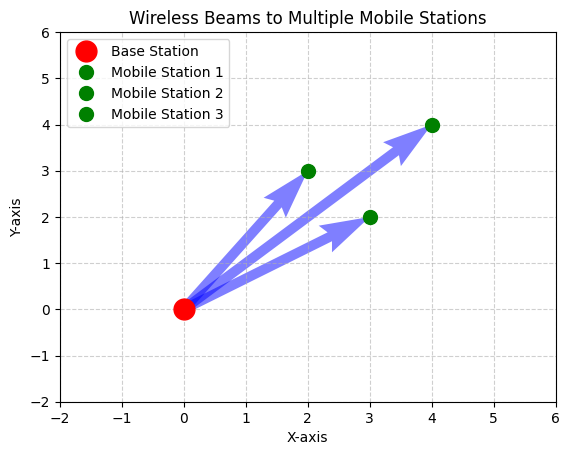

In [11]:
import matplotlib.pyplot as plt
import numpy as np

bs_x, bs_y = 0, 0

ms_coordinates = [(4, 4), (2, 3), (3, 2)]

fig, ax = plt.subplots()

ax.plot(bs_x, bs_y, 'ro', markersize=15, label='Base Station')

for idx, (ms_x, ms_y) in enumerate(ms_coordinates):
    ax.plot(ms_x, ms_y, 'go', markersize=10, label=f'Mobile Station {idx + 1}')

for ms_x, ms_y in ms_coordinates:
    beam_vector = np.array([ms_x - bs_x, ms_y - bs_y])
    ax.quiver(
        bs_x, bs_y, beam_vector[0], beam_vector[1],
        angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5, width=0.02
    )

ax.set_xlim(-2, 6)
ax.set_ylim(-2, 6)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Wireless Beams to Multiple Mobile Stations')
ax.legend()

ax.grid(True, linestyle='--', alpha=0.6, which='both')

plt.savefig('mimo_system.png')
plt.show()
